In [716]:
import os
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from scipy.stats import gaussian_kde
from scipy.stats._kde import gaussian_kde as TGaussianKDE

import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

usr = os.path.expanduser("~")

In [656]:
X, y = make_classification(
    n_samples=400,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=42,
)

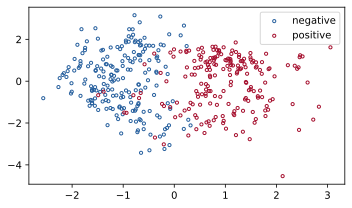

In [733]:
plt.subplots(1, 1, figsize=(5, 3))
for i, (label, color) in enumerate(
    (
        ("negative", "#235d9c"),
        ("positive", "#a40c2b")
    )
):
    mask = y == i
    plt.scatter(
        X[mask, 0], X[mask, 1], s=10, label=label, edgecolors=color, facecolors="none")

fig_path = os.path.join(
    usr, "Documents/site/assets/img/binary_problem.svg"
)
plt.tight_layout()
plt.legend()
plt.savefig(fig_path, transparent=True)
plt.show()

In [531]:
X_with_y = np.column_stack([X, y])

dist = gaussian_kde(X_with_y.T)

In [618]:
marginal_dist = dist.marginal([0, 1])
test = [ 0.8006456 ,  1.14226238]

print(marginal_dist.pdf(test))
print(dist.pdf(test + [0]) + dist.pdf(test + [1]))

[0.07661607]
[0.17057924]


In [502]:
def create_mesh(X: np.array, y: np.array) -> tuple[np.array, np.array]:
    x_min, y_min = X.min(axis=0).round() - 0.5
    x_max, y_max = X.max(axis=0).round() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )
    
    return xx, yy  

In [553]:
def plot_joint_pdf(X: np.array, y: np.array, dist: TGaussianKDE) -> None:
    xx, yy = create_mesh(X, y) 
    n = xx.size
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    X_pos = np.c_[xx.ravel(), yy.ravel(), np.ones(n)].T
    X_neg = np.c_[xx.ravel(), yy.ravel(), np.zeros(n)].T
    Z_pos = dist.pdf(X_pos)
    Z_neg = dist.pdf(X_neg)
    Z = Z_pos - Z_neg
    Z = Z.reshape(xx.shape)
        
    ax.contour(xx, yy, Z, alpha=1, cmap="RdBu_r")
    for j, color in enumerate(("#235d9c", "#a40c2b")):
        mask = y == j
        ax.scatter(
            X[mask, 0], X[mask, 1], s=10, edgecolors=color, facecolors="none",
        )
        
    ax.set_title(f"Probabiltiy Density Function of $p(x,y)$")
    
    fig_path = os.path.join(
        usr, "Documents/site/assets/img/joint_pdf.svg"
    )

    plt.tight_layout()    
    plt.savefig(fig_path, transparent=True)
    plt.show()

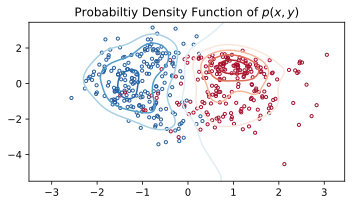

In [554]:
plot_joint_pdf(X, y, dist)

`KDEClassifier` implements

$$
p(y|x) = \frac{p(x, y)}{\sum_{\forall y' \in y}p(x, y')}
$$

In [767]:
class KDEClassifier:
        
    def fit(self, X: np.array, y: np.array) -> None:
        X_with_y = np.column_stack([X, y])
        self.dist = gaussian_kde(X_with_y.T)
        
    def predict_proba_density(self, X: np.array) -> np.array:
        y_pos = np.ones(len(X))
        y_neg = y_pos - 1
        X_with_pos = np.column_stack([X, y_pos]).T
        X_with_neg = np.column_stack([X, y_neg]).T
        
        proba_densities = [
            self.dist.pdf(X_with_)
            / (self.dist.pdf(X_with_neg) + self.dist.pdf(X_with_pos))
            for X_with_ in (X_with_neg, X_with_pos)
        ]
        
        return np.column_stack(proba_densities)
    
    def predict(self, X: np.array) -> np.array:
        proba_densities = self.predict_proba_density(X)
        return np.argmax(proba_densities, axis=1)

In [768]:
kde_classifier = KDEClassifier()
kde_classifier.fit(X, y)

lr_classifier = SGDClassifier(loss="log_loss", random_state=0)
lr_classifier.fit(X, y)

print(classification_report(y, lr_classifier.predict(X)))
print(classification_report(y, kde_classifier.predict(X)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       201
           1       0.93      0.92      0.92       199

    accuracy                           0.93       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.93      0.92       400

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       201
           1       0.97      0.92      0.94       199

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400



In [747]:
def plot_regions(
    X: np.array,
    y: np.array,
    kde_classifier: KDEClassifier,
    lr_classifier: SGDClassifier
) -> None:
    xx, yy = create_mesh(X, y)
    n = xx.size
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    for i, model in enumerate((kde_classifier, lr_classifier)):
        
        X_ = np.c_[xx.ravel(), yy.ravel()]
        if isinstance(model, KDEClassifier):
            model_name = "KDE Classifier"
            Z = model.predict_proba_density(X_)[:, 0]
        else:
            model_name = "Logistic Regression"
            Z = model.predict_proba(X_)[:, 1]
        Z = Z.reshape(xx.shape)
        
        y_pred = model.predict(X)
        metrics = (
            f"Precision = {precision_score(y, y_pred):.2f}\n"
            f"Recall = {recall_score(y, y_pred):.2f}\n"
            f"Accuracy = {accuracy_score(y, y_pred):.2f}"
        )
        
        ax[i].contour(xx, yy, Z, alpha=1, cmap='RdBu_r')
        ax[i].text(
            -3.2, -5, metrics,
            bbox={"boxstyle": "round", "facecolor": "none"},
            fontsize=8
        )
        for j, color in enumerate(("#235d9c", "#a40c2b")):
            mask = y == j
            ax[i].scatter(
                X[mask, 0], X[mask, 1], s=10, edgecolors=color, facecolors="none"
            )
        
        ax[i].set_title(model_name)
        
    fig_path = os.path.join(
        usr, "Documents/site/assets/img/classifier_comparison.svg"
    )
    plt.tight_layout()
    plt.savefig(fig_path, transparent=True)
    plt.show()

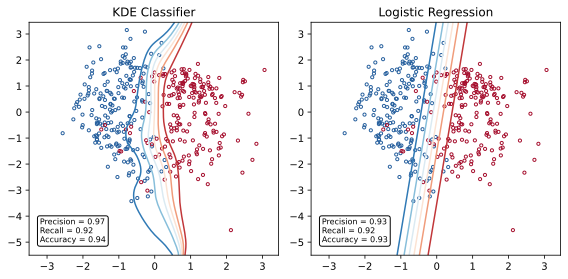

In [748]:
plot_regions(X, y, kde_classifier, lr_classifier)